# UFC Retirement Age - Modeling

## 1. Contents<a id='1._Contents'></a>
* [UFC Retirement Age - Modeling](#UFC_Retirement_Age_-_Modeling)
  * [1. Contents](#1._Contents)
  * [2. Sourcing and Loading](#2._Sourcing_and_Loading)
    * [2a. Import relevant libraries](#2a._Import_relevant_libraries)
    * [2b. Load previously preprocessed DataFrame](#2b._Load_previously_preprocessed_DataFrame)
    * [2c. Preliminary exploration of data](#2c._Preliminary_exploration_of_data)
  * [3. Additional Data Wrangling](#3._Additional_Data_Wrangling)
    * [3a. Bout columns](#3a._Bout_columns)
    * [3b. Isolating X and y columns](#3b._Isolating_X_and_y_columns)
    * [3c. Removing null columns](#3c._Removing_null_columns)
    * [3d. Remove outlier row](#3e._Remove_outlier_row)
  * [4. Modeling](#4._Modeling)
    * [4a. Comparing multivariate linear regression with model based on mean](#4a._Finding_best_features_for_linear_regression_model)
    * [4b. `Winner` based on `age`](#4b._Finding_best_features_for_random_forest_regressor)
    * [4c. `Winner` based on `age_dif`](#4c._Choosing_best_model)
    * [4d. `Winner` vs. every column](#4c._Choosing_best_model)
  * [5. Conclusion](#5._Conclusion)

## 2. Sourcing and Loading <a id='2._Sourcing_and_Loading'></a>

**2a. Import relevant libraries** <a id='2a._Import_relevant_libraries'></a>

In [162]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import kaggle as kg
import pandas as pd
import missingno as msno
import statsmodels.api as sm
import scipy.stats
from matplotlib.lines import Line2D
from kaggle.api.kaggle_api_extended import KaggleApi
from statsmodels.graphics.api import abline_plot
from sklearn.metrics import mean_squared_error, r2_score, classification_report, confusion_matrix, accuracy_score, \
plot_roc_curve, roc_curve, roc_auc_score, precision_recall_curve, auc
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model, preprocessing
from zipfile import ZipFile
from scipy import stats
from scipy.stats import t
from scipy.stats import ttest_ind
from scipy.stats import mannwhitneyu
from numpy.random import seed
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")

**2b. Load previously preprocessed DataFrame** <a id='2b._Load_previously_preprocessed_DataFrame'></a>

In [2]:
df = pd.read_csv('df.csv', index_col=0)
df.head()

,date,fighter,odds,Winner,title_bout,current_lose_streak,current_win_streak,draw,avg_SIG_STR_landed,avg_SIG_STR_pct,...,weight_class_Middleweight,weight_class_Welterweight,weight_class_Women's Bantamweight,weight_class_Women's Featherweight,weight_class_Women's Flyweight,weight_class_Women's Strawweight,gender_MALE,Stance_Orthodox,Stance_Southpaw,Stance_Switch
0,2020-10-03,Holly Holm,-125,1,0,0,1,0,2.75,0.35,...,0,0,1,0,0,0,0,0,1,0
1,2020-10-03,Irene Aldana,103,0,0,0,2,0,6.16,0.38,...,0,0,1,0,0,0,0,1,0,0
2,2020-10-03,Yorgan De Castro,-265,0,0,1,0,0,2.19,0.41,...,0,0,0,0,0,0,1,1,0,0
3,2020-10-03,Carlos Felipe,205,1,0,1,0,0,2.93,0.36,...,0,0,0,0,0,0,1,1,0,0
4,2020-10-03,Germaine de Randamie,-150,1,0,1,0,0,2.72,0.47,...,0,0,1,0,0,0,0,1,0,0


**2c. Preliminary exploration of data** <a id='2c._Preliminary_exploration_of_data'></a>

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8816 entries, 0 to 8815
Columns: 103 entries, date to Stance_Switch
dtypes: float64(29), int64(72), object(2)
memory usage: 7.0+ MB


In [4]:
df.shape

(8816, 103)

In [5]:
df.columns

Index(['date', 'fighter', 'odds', 'Winner', 'title_bout',
       'current_lose_streak', 'current_win_streak', 'draw',
       'avg_SIG_STR_landed', 'avg_SIG_STR_pct',
       ...
       'weight_class_Middleweight', 'weight_class_Welterweight',
       'weight_class_Women's Bantamweight',
       'weight_class_Women's Featherweight', 'weight_class_Women's Flyweight',
       'weight_class_Women's Strawweight', 'gender_MALE', 'Stance_Orthodox',
       'Stance_Southpaw', 'Stance_Switch'],
      dtype='object', length=103)

# 3. Additional Data Wrangling <a id='3._Additional_Data_Wrangling'></a>

**3a. Bout columns** <a id='3a._Bout_columns'></a>

Many of the bout columns provide stats on the entire bout, but since some fights end in the first round and others can go all 5 rounds, these columns would be much more helpful to us if they gave us an average over the seconds spent in the fight. 

In [6]:
bout_data = [column for column in df.columns if column.endswith(('d_bout','s_bout','v_bout'))]
bout_data

['kd_bout',
 'sig_str_landed_bout',
 'sig_str_attempted_bout',
 'tot_str_landed_bout',
 'tot_str_attempted_bout',
 'td_landed_bout',
 'td_attempted_bout',
 'sub_attempts_bout',
 'pass_bout',
 'rev_bout']

In [7]:
for column in df[bout_data].columns:
    df[column] = df[column] / df['total_fight_time_secs']
    
df[bout_data].describe()

,kd_bout,sig_str_landed_bout,sig_str_attempted_bout,tot_str_landed_bout,tot_str_attempted_bout,td_landed_bout,td_attempted_bout,sub_attempts_bout,pass_bout,rev_bout
count,5544.000000,5544.000000,5544.000000,5544.000000,5544.000000,5544.000000,5544.000000,5544.000000,5544.000000,5544.000000
mean,0.001265,0.062168,0.137246,0.086543,0.165105,0.001710,0.004524,0.000890,0.001871,0.000218
std,0.006181,0.054308,0.092434,0.062350,0.094618,0.002944,0.005811,0.002817,0.003806,0.001217
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.031111,0.076706,0.048889,0.103433,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.051111,0.121111,0.074266,0.151111,0.000000,0.002661,0.000000,0.000000,0.000000
75%,0.000000,0.077778,0.176287,0.107778,0.204372,0.002222,0.006667,0.000000,0.002222,0.000000
max,0.142857,0.857143,1.428571,0.857143,1.428571,0.041667,0.068966,0.071429,0.058824,0.071429


In [8]:
secs_data = [column.replace('_bout', '_per_sec') for column in bout_data]
secs_data

['kd_per_sec',
 'sig_str_landed_per_sec',
 'sig_str_attempted_per_sec',
 'tot_str_landed_per_sec',
 'tot_str_attempted_per_sec',
 'td_landed_per_sec',
 'td_attempted_per_sec',
 'sub_attempts_per_sec',
 'pass_per_sec',
 'rev_per_sec']

In [9]:
for bout_column, secs_column in zip(bout_data, secs_data):
    df.rename({bout_column: secs_column}, axis=1, inplace=True)

df[secs_data].tail()

,kd_per_sec,sig_str_landed_per_sec,sig_str_attempted_per_sec,tot_str_landed_per_sec,tot_str_attempted_per_sec,td_landed_per_sec,td_attempted_per_sec,sub_attempts_per_sec,pass_per_sec,rev_per_sec
8811,0.0,0.042553,0.127660,0.042553,0.127660,0.000000,0.042553,0.000000,0.000000,0.000000
8812,0.0,0.043333,0.084444,0.100000,0.145556,0.006667,0.011111,0.000000,0.006667,0.000000
8813,0.0,0.018889,0.068889,0.034444,0.084444,0.000000,0.000000,0.000000,0.000000,0.000000
8814,0.0,0.030000,0.090000,0.057778,0.118889,0.002222,0.003333,0.001111,0.001111,0.001111
8815,0.0,0.077778,0.161111,0.144444,0.228889,0.003333,0.006667,0.001111,0.006667,0.001111


**3b. Isolating X and y columns** <a id='3b._Isolating_X_and_y_columns'></a>

`age` is going to be our dependent variable, while our independent variables are going to be based on fight performance.

In [10]:
fight_perf = ['Winner','finish'] + secs_data
fight_perf

['Winner',
 'finish',
 'kd_per_sec',
 'sig_str_landed_per_sec',
 'sig_str_attempted_per_sec',
 'tot_str_landed_per_sec',
 'tot_str_attempted_per_sec',
 'td_landed_per_sec',
 'td_attempted_per_sec',
 'sub_attempts_per_sec',
 'pass_per_sec',
 'rev_per_sec']

**3c. Removing null columns** <a id='3c._Removing_null_columns'></a>

In [11]:
df_no_null = df[df[fight_perf].notnull().all(axis=1)]
df_no_null[fight_perf].isnull().sum()

Winner                       0
finish                       0
kd_per_sec                   0
sig_str_landed_per_sec       0
sig_str_attempted_per_sec    0
tot_str_landed_per_sec       0
tot_str_attempted_per_sec    0
td_landed_per_sec            0
td_attempted_per_sec         0
sub_attempts_per_sec         0
pass_per_sec                 0
rev_per_sec                  0
dtype: int64

In [12]:
df_no_null.reset_index(inplace=True)

**3d. Remove outlier row** <a id='3e._Remove_outlier_row'></a>

In [17]:
df_no_null[df_no_null['action_per_sec'] > 60]

,index,date,fighter,odds,Winner,title_bout,current_lose_streak,current_win_streak,draw,avg_SIG_STR_landed,...,weight_class_Welterweight,weight_class_Women's Bantamweight,weight_class_Women's Featherweight,weight_class_Women's Flyweight,weight_class_Women's Strawweight,gender_MALE,Stance_Orthodox,Stance_Southpaw,Stance_Switch,action_per_sec
3144,5250,2015-02-28,Ronda Rousey,-660,1,1,0,4,0,18.75,...,0,1,0,0,0,0,1,0,0,67.321805


In [18]:
df_no_null.drop(index=3144, inplace=True)
df_no_null[df_no_null['action_per_sec'] > 60]

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,index,date,fighter,odds,Winner,title_bout,current_lose_streak,current_win_streak,draw,avg_SIG_STR_landed,...,weight_class_Welterweight,weight_class_Women's Bantamweight,weight_class_Women's Featherweight,weight_class_Women's Flyweight,weight_class_Women's Strawweight,gender_MALE,Stance_Orthodox,Stance_Southpaw,Stance_Switch,action_per_sec


# 4. Modeling <a id='4._Modeling'></a>

**4a. Comparing multivariate linear regression with model based on mean** <a id='4a._Comparing_multivariate_linear_regression_with_model_based_on_mean'></a>

In [176]:
X = df_no_null['age'].values.reshape(-1,1)
y = df_no_null[fight_perf]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

mean_mae = np.mean(abs(y_train.mean() - y_test))
mean_mae

Winner                       0.500024
finish                       3.259968
kd_per_sec                   0.002177
sig_str_landed_per_sec       0.034611
sig_str_attempted_per_sec    0.064626
tot_str_landed_per_sec       0.043084
tot_str_attempted_per_sec    0.066460
td_landed_per_sec            0.001989
td_attempted_per_sec         0.004150
sub_attempts_per_sec         0.001280
pass_per_sec                 0.002417
rev_per_sec                  0.000376
dtype: float64

In [177]:
model = LinearRegression()
model.fit(X_train, y_train)
model_mae = np.mean(abs(model.predict(X_test) - y_test))
model_mae

Winner                       0.497655
finish                       3.242690
kd_per_sec                   0.002183
sig_str_landed_per_sec       0.034709
sig_str_attempted_per_sec    0.064717
tot_str_landed_per_sec       0.043132
tot_str_attempted_per_sec    0.066525
td_landed_per_sec            0.001986
td_attempted_per_sec         0.004155
sub_attempts_per_sec         0.001268
pass_per_sec                 0.002409
rev_per_sec                  0.000377
dtype: float64

In [178]:
dif = mean_mae - model_mae
per_change = dif / mean_mae * 100
per_change

Winner                       0.473870
finish                       0.529997
kd_per_sec                  -0.290018
sig_str_landed_per_sec      -0.282579
sig_str_attempted_per_sec   -0.140897
tot_str_landed_per_sec      -0.113049
tot_str_attempted_per_sec   -0.098606
td_landed_per_sec            0.125042
td_attempted_per_sec        -0.125099
sub_attempts_per_sec         0.894982
pass_per_sec                 0.326918
rev_per_sec                 -0.368533
dtype: float64

Compared to a simple linear regression based on the mean, our multivariate regression based on fighter age is not much better at predicting fight metrics. In fact, our regression model did worse on more metrics than better. These performance stats are most likely not correlated with age.

In [180]:
per_change.mean()

0.07766893321936819

Even when we average out the improvement of the model over a simple mean-based model, the improvement is very weak. Overall, our multivariate linear regression model predicts fight performance **0.78%** better than a simple linear regression model based on the mean.

**4b. `Winner` based on `age`**

Since `Winner` is a categorical variable, we should see if a logistic regression based on `age` will fare better in predictability power.

AUC: 0.557


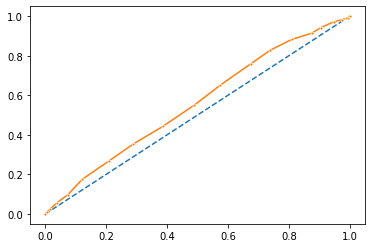

In [189]:
X = df_no_null['age'].values.reshape(-1,1)
y = df_no_null['Winner']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

model = LogisticRegression().fit(X_train, y_train)

probs = model.predict_proba(X_test)
probs = probs[:,1]

fpr, tpr, thresholds = roc_curve(y_test, probs)
sns.lineplot([0,1], [0,1], linestyle='--')
plt = sns.lineplot(fpr, tpr, marker='.')
auc_score = roc_auc_score(y_test, probs)
print('AUC: %.3f' % auc_score)

With an AUC score of **.557**, this model performs barely better than a mean-based model, and is not effective at predicting `Winner` based on `age`.

**4c. `Winner` based on `age_dif`**

AUC: 0.560


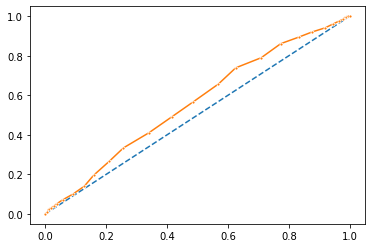

In [195]:
X = df_no_null[['age_dif']]
y = df_no_null['Winner']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

model = LogisticRegression().fit(X_train, y_train)

probs = model.predict_proba(X_test)
probs = probs[:,1]

fpr, tpr, thresholds = roc_curve(y_test, probs)
sns.lineplot([0,1], [0,1], linestyle='--')
plt = sns.lineplot(fpr, tpr, marker='.')
auc_score = roc_auc_score(y_test, probs)
print('AUC: %.3f' % auc_score)

Even `age_dif` is not a good predictor of `Winner`.

AUC: 0.532


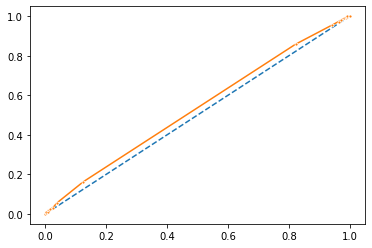

In [201]:
X = df_no_null[['total_title_bouts_dif']]
y = df_no_null['Winner']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

model = LogisticRegression().fit(X_train, y_train)

probs = model.predict_proba(X_test)
probs = probs[:,1]

fpr, tpr, thresholds = roc_curve(y_test, probs)
sns.lineplot([0,1], [0,1], linestyle='--')
plt = sns.lineplot(fpr, tpr, marker='.')
auc_score = roc_auc_score(y_test, probs)
print('AUC: %.3f' % auc_score)

**4d. `Winner` vs. every column**

Just for fun, I will find out which single feature in the entire dataset would be the best predictor for `Winner`.

In [244]:
from pandas.api.types import is_numeric_dtype

auc = {}
df_numeric = [column for column in df.columns if is_numeric_dtype(df[column])]
df_numeric.remove('Winner')
df_numeric.remove('finish')

for column in df_numeric:
    df = df[df[column].notna()]
    X = df[[column]]
    y = df['Winner']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    
    model = LogisticRegression().fit(X_train, y_train)

    probs = model.predict_proba(X_test)
    probs = probs[:,1]
    auc_score = roc_auc_score(y_test, probs)

    auc[column] = auc_score
    
print(sorted(auc.items(), key=lambda x:x[1], reverse=True)[:5])

[('tot_str_landed_per_sec', 0.7688876651982379), ('odds', 0.7242915535072558), ('sig_str_pct_bout', 0.7010527008716737), ('sig_str_landed_per_sec', 0.6946481762876248), ('tot_str_attempted_per_sec', 0.689480473145429)]


It looks like the top 5 predictors for whether a fighter will win or not are `tot_str_landed_per_sec`, `odds`, `sig_str_landed_per_sec`, `sig_str_pct_bout`, and `tot_str_attempted_per_sec`. It makes particular sense for `odds` to be on this list, as these odds are generated by teams of professionals, so it follow that that their predictions would be accurate. Moreover, all the other features with high predictive power have to do with the fighter's performance *during* the fight, so they wouldn't be of much help in determining `Winner` before the fight begins. 

# 5. Conclusion <a id='5._Conclusion'></a>

Despite our best efforts to fit a model to the data, we were unsuccessful in our efforts to predict any sort of fight metric based on a fighter's age. Although our exploratory data analysis found a significant difference in `age` between several different fight metrics, a linear regression model based on `age` did not yield a better model compared to a simple model where we pick the mean every time. When it came to a classification model for `Winner`, `age` did not fare much better. In fact, it seems like the only pre-fight feature (that we have access to) that can predict the `Winner` of a fight is `odds`, which means the people in Las Vegas who are coming up with these `odds` are doing their jobs right. 

**Further work:** The dataset that we used only contained information from fights starting in 2010 and beyond. However, the UFC had its first fight in 1993, so our dataset was missing 17 years of data. It is possible that we could have build a more accurate model with this missing data. However, acquiring that missing data personally would take a lot of time and research. 